# Introduction

This Notebook retrieves the top 360 repositories off of PyPi in order to analyze their parse trees. I perform some simple statistical analysis with Pandas near the end to answer some question that had been bothering me. The main one is, "Do we use more `for` loops or `while` loops in Python?

Since we're going with the top 360 repositories, we're not really getting a high percentage of the total Python code in the world. Further, we're getting a biased subset since these will be libraries, which will have a different style to them than most of the code out there. There's further bias since these will be *popular* libraries, which means you might expect them to have better code than average.

My analysis is not perfect - it simply downloads the source code from PyPi as best it can, and then looks for any valid, parseable file that ends in a `.py` extension. I haven't looked to see how many potential files it rejects for invalid characters/syntax/etc. The extent of my analysis is also quite simplistic: I end up with the raw frequency of each type of AST element (e.g., `Assign`, `FunctionDef`, or `Name` nodes) across all the files. It would be relatively easy to extend my analysis further to do more analysis on a per-package or per-file basis.

# Imports

In [37]:
import sys
import os
import json
import random
import subprocess
import ast
from pprint import pprint
from zipfile import ZipFile, BadZipFile
import tarfile
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import requests
from bs4 import BeautifulSoup

# Optionally have a progress bar
try:
    from tqdm import tqdm, tqdm_notebook
except:
    tqdm = list
    tqdm_notebook= list
    
# Optionally have a cache in case you are interrupted
try:
    import requests_cache
    requests_cache.install_cache('python_asts')
except:
    pass

# Configuration options

In [92]:
temp_package_folder = os.path.join(os.getcwd(), 'packages')

# Retrieve Packages

Using a list of popular Python packages, we will download them using Pip.

The packages (wheels and tar.gz files) will be stored in a `packages/` directory.

This can take a little while.

In [ ]:
# Load names
with open('popular_names.json', 'r') as popular_names_file:
    package_names = json.load(popular_names_file)

# Download packages using Pip
# Warning, takes a while
for package_name in tqdm_notebook(package_names):
    commands = [sys.executable, '-m', 
                # Actually download the package
                'pip', 'download', package_name,
                # Just the source code, nothing else
                "--no-deps", "--no-binary",
                # Only Python 3
                "--python-version", "3", 
                # Only Pure Python
                "--implementation", "pp",
                # Store locally, easier to delete afterwards
                "--dest", temp_package_folder]
    try:
        subprocess.check_call(commands)
    except subprocess.CalledProcessError as e:
        print("Package failed:", package_name, "\n", e)

# Process Packages

Process the packages by loading each one in turn

In [39]:
class AstCounter(ast.NodeVisitor):
    '''
    Simple class for traversing ASTs and recording
    the different types of nodes we encounter.
    '''
    def __init__(self):
        self.elements = Counter()
    def generic_visit(self, node):
        '''
        Consumes an AST node, counts it, and then checks its children.
        '''
        name = type(node).__name__
        self.elements[name] += 1
        ast.NodeVisitor.generic_visit(self, node)
    def parse_file(self, python_file):
        '''
        Parse and count the elements of a python program.
        
        Returns nothing if it fails - e.g., because there was a Null Byte in the
        string or the file was not a parseable Python program.
        
        Args:
            python_file (str): The contents of a python program (note the filename).
        '''
        try:
            parsed = ast.parse(python_file)
        except SyntaxError:
            return None
        except ValueError:
            return None
        self.visit(parsed)

In [5]:
class PackageException(Exception):
    pass

def process_tar(package_path):
    try:
        tarred_package = tarfile.open(package_path)
    except tarfile.TarError:
        raise PackageException()
    for member in tarred_package.getmembers():
        if member.name.endswith('.py'):
            try:
                contents = tarred_package.extractfile(member).read()
            except KeyError:
                continue
            yield (member.name, contents)

def process_zip(package_path):
    try:
        zipped_package = ZipFile(package_path)
    except BadZipFile:
        raise PackageException()
    for inner_filename in zipped_package.namelist():
        if inner_filename.endswith('.py'):
            with zipped_package.open(inner_filename) as python_file:
                yield (inner_filename, python_file.read())

process_dispatcher = {
    'whl': process_zip,
    'bz2': process_tar,
    '.gz': process_tar,
    'tgz': process_tar,
    'zip': process_zip,
}

The following code actually iterates through the packages and parses
their contents. This can take a little while (about 4 minutes on my machine), so I've added a progress bar.

In [40]:
counter = AstCounter()
packages = os.listdir(temp_package_folder)

progress_bar = tqdm_notebook(packages)

# Walk through all the packages on disk
for package_filename in progress_bar:
    if tqdm_notebook is not list:
        progress_bar.set_description(package_filename)
    package_path = os.path.join(temp_package_folder, package_filename)
    # Try to extract the python files
    try:
        python_files = process_dispatcher[package_path[-3:]](package_path)
    except PackageException:
        print("Bad package (skipping):", package_filename)
        print("\tPath:", package_path)
        continue
    # Parse each file for its AST
    for python_filename, python_file in python_files:
        counter.parse_file(python_file)

HBox(children=(IntProgress(value=0, max=359), HTML(value='')))

# Analyze Results

Load the data into a Pandas DataFrame and calculate some statistics (the ratio of elements).

In [41]:
df = pd.DataFrame.from_dict(counter.elements, orient='index')
df.columns = ['Frequency']
df = df.sort_values(by='Frequency', ascending=False)
df['%'] = ((df.Frequency / df.Frequency.sum()) * 100).round(2)

Let's look at the top 10 elements. As you might expected, the top few slots are all dominated by variable and attribute access, followed by function calls. I suppose I shouldn't be surprised that string literals outnumber numeric literals, given how their used in documentation within Python. Also unsurprising is that Assignment is the most popular statement.

In [50]:
df.head(10)

,Frequency,%
Load,7862948,25.52
Name,5989398,19.44
Attribute,2393232,7.77
Call,1956344,6.35
Str,1811482,5.88
Store,1355253,4.40
Num,1207683,3.92
Assign,1071627,3.48
Expr,740525,2.40
arg,675312,2.19


The least common elements reflect new Python features: asynchronous keywords and the nonlocal modifier. I do find it interesting that dictionary and set comprehensions are so rare, but I am not at all surprised that Ellipsis and the unary addition operator have little presence. I wonder how many of those UAdd are just plain mistakes?

In [52]:
df.tail(10)

,Frequency,%
DictComp,777,0.0
Ellipsis,600,0.0
UAdd,374,0.0
SetComp,321,0.0
YieldFrom,187,0.0
Await,180,0.0
AsyncFunctionDef,136,0.0
Nonlocal,54,0.0
AsyncFor,13,0.0
AsyncWith,10,0.0


## Specific Questions

This was all triggered by my curiousity about a few specific questions.

### For vs. While

First of all, is it true that `for` loops are much more common than `while` loops in Python? Yes!

In [24]:
fors = df.loc['For'].Frequency.astype(int)
whiles = df.loc['While'].Frequency.astype(int)
print("For loop:", fors)
print("While loop:", whiles)
print("There are about", int(round(fors/whiles)), "times as many FOR loops as WHILE loops.")

For loop: 68022
While loop: 7110
There are about 10 times as many FOR loops as WHILE loops.


### 2. Global

How often are people using the global keyword? Almost never - as it should be!

In [29]:
print("Frequency:", df.loc['Global']['Frequency'].astype(int))
print("% (rounded):", df.loc['Global']['%'])

Frequency: 1200
% (rounded): 0.0


### 3. Elements per Module

The Module element will give us a good estimate of the number of Python files we processed. This can give us some basic descriptive statistics. Unfortunately, it's only a rough average - we know nothing about the distribution from this analysis, which I would suspect has a long tail.

In [36]:
modules = df.loc['Module'].Frequency.astype(int)

average_elements_per_module = int(round(df.Frequency.sum() / modules))

print("Average elements per module:", average_elements_per_module)

Average elements per module: 1148


### 4. Distribution of Element Frequencies

The range of elements is pretty wide - to visualize this, I've constructed the histogram below. The X-axis has various frequency counts of AST elements, and the Y-axis is the number of elements that occur with that frequency.

Note that the X-axis has been scaled logarithmically (base 10). So the modal value is between 10,000-100,000, which is a pretty massive range. The long tail of the unskewed graph is pretty overwhelming. Still, I never stop being surprised at how often a normal distribution occurs in the wild, even if some light transformations were required to get there.

There's not much to take away from this graph: elements have a lot of diversity in their frequency.

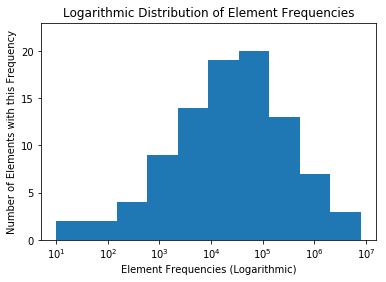

In [90]:
plt.hist(np.log10(df.Frequency))
plt.title("Logarithmic Distribution of Element Frequencies")
plt.xlabel("Element Frequencies (Logarithmic)")
plt.ylabel("Number of Elements with this Frequency")
xs = range(1, 8)
plt.xticks(xs, ["$10^{}$".format(x) for x in xs])
plt.ylim(0, 23)
plt.show()

## Full Table

For those interested in finding a specific element, the full table is below.

In [45]:
from IPython.core.display import HTML
display(HTML(df.to_html()))

,Frequency,%
Load,7862948,25.52
Name,5989398,19.44
Attribute,2393232,7.77
Call,1956344,6.35
Str,1811482,5.88
Store,1355253,4.40
Num,1207683,3.92
Assign,1071627,3.48
Expr,740525,2.40
arg,675312,2.19
